# Trains and evaluate the 2020 extended classifier

In [1]:
from deepcell.datasets.visual_behavior_extended_dataset import VisualBehaviorExtendedDataset
from deepcell.classifier import Classifier
from deepcell.models.VggBackbone import VggBackbone
from deepcell.data_splitter import DataSplitter
from deepcell.transform import Transform
from deepcell.inference import inference
from deepcell.plotting import pr_curve

import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from imgaug import augmenters as iaa
import random
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import average_precision_score

random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [2]:
!git rev-parse --short HEAD

c1b6780


In [3]:
ARTIFACT_DESTINATION = Path('/tmp/artifacts')
CHECKPOINT_PATH = Path('.').absolute().parent.parent / 'saved_models' / '2020_extended_classifier_111721'

In [4]:
dataset = VisualBehaviorExtendedDataset(artifact_destination=ARTIFACT_DESTINATION, 
                                        exclude_projects=[
                                            'ophys-experts-slc-oct-2020_ophys-experts-go-big-or-go-home', 
                                            'ophys-expert-danielsf-additions'])

INFO:deepcell.datasets.visual_behavior_dataset:Reading manifests and preprocessing
INFO:deepcell.datasets.visual_behavior_dataset:Dataset already downloaded...


In [5]:
len(dataset.dataset)

2331

In [6]:
dataset.project_meta.groupby('project_name')['date'].agg(['min', 'max'])

/tmp/ipykernel_3897/1972182134.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  dataset.project_meta.groupby('project_name')['date'].agg(['min', 'max'])


,min,max
project_name,,
add_vasculature,2021-11-11 00:00:00.000,2021-11-11 00:00:00.000
ophys-experts-go-big-or-go-home,2020-11-27 22:47:25.996,2020-12-04 00:41:02.252
ophys-experts-slc-oct-2020,2020-10-26 18:41:36.928,2020-10-29 03:07:02.104


In [7]:
dataset.project_meta.groupby('project_name').size()

project_name
add_vasculature                     244
ophys-experts-go-big-or-go-home    1598
ophys-experts-slc-oct-2020          489
dtype: int64

In [8]:
all_transform = transforms.Compose([
    iaa.Sequential([
        iaa.Sometimes(0.5, iaa.Affine(rotate=(-360, 360), order=0)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.CenterCropToFixedSize(height=60, width=60),
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform = Transform(all_transform=all_transform)

In [9]:
all_transform = transforms.Compose([
    iaa.Sequential([
        iaa.CenterCropToFixedSize(height=60, width=60)
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = Transform(all_transform=all_transform)

In [10]:
data_splitter = DataSplitter(model_inputs=dataset.dataset, train_transform=train_transform,
                             test_transform=test_transform, seed=1234, image_dim=(128, 128))
train, test = data_splitter.get_train_test_split(test_size=.3)
train_dataloader = DataLoader(dataset=train, shuffle=True, batch_size=32)

In [11]:
print(len(train) + len(test))
print(train.y.mean())
print(len(test))

2331
0.23421213979153893
700


In [12]:
cnn = torchvision.models.vgg11_bn(pretrained=True, progress=False)

In [13]:
cnn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
cnn = torchvision.models.vgg11_bn(pretrained=True, progress=False)
cnn = VggBackbone(model=cnn, truncate_to_layer=15, classifier_cfg=[512, 512], dropout_prob=.7, freeze_up_to_layer=15)
optimizer = lambda: torch.optim.Adam(cnn.classifier.parameters(), lr=0.0004, weight_decay=0.0)
pos_weight = torch.tensor([2.0])
if torch.cuda.is_available():
    pos_weight = pos_weight.cuda()
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
scheduler = lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=40, verbose=True, factor=.5)
classifier = Classifier(model=cnn, n_epochs=1000, optimizer=optimizer, scheduler=scheduler,
                        criterion=criterion, save_path=CHECKPOINT_PATH, early_stopping=60)
cv_metrics = classifier.cross_validate(train_dataset=train, data_splitter=data_splitter, batch_size=32, 
                                       save_model=True)

In [15]:
cv_metrics.metrics

{'train_loss': 0.2691265612840652, 'valid_loss': 0.31010706837035035}

In [33]:
def calc_cv_metrics():
    auprs = np.array([cv_metrics.valid_metrics[i].auprs[cv_metrics.valid_metrics[i].best_epoch] 
                      for i in range(len(cv_metrics.valid_metrics))])
    return auprs.mean(), auprs.std()
calc_cv_metrics()

(0.8992637369899394, 0.03964500217331202)

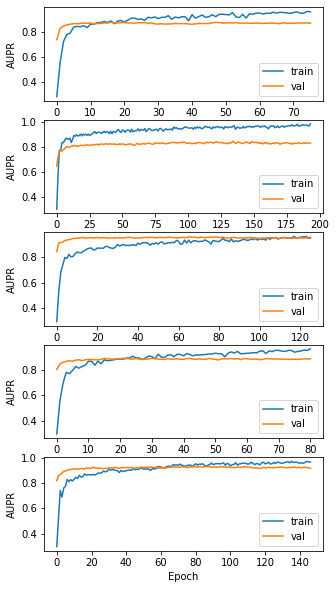

In [16]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(5, 10))

for i in range(5):
    ax[i].plot(cv_metrics.train_metrics[i].auprs[:cv_metrics.train_metrics[i].best_epoch + 60], label='train')
    ax[i].plot(cv_metrics.valid_metrics[i].auprs[:cv_metrics.train_metrics[i].best_epoch + 60], label='val')
    ax[i].legend()
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('AUPR')

plt.show()

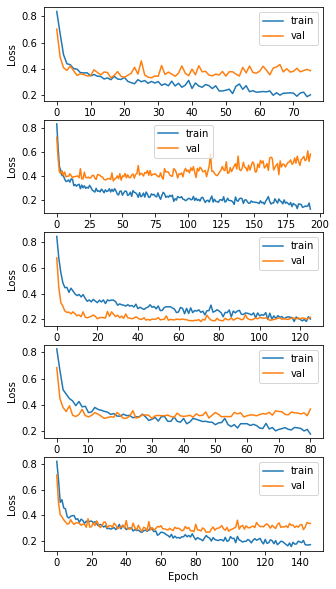

In [17]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(5, 10))

for i in range(5):
    ax[i].plot(cv_metrics.train_metrics[i].losses[:cv_metrics.train_metrics[i].best_epoch + 60], label='train')
    ax[i].plot(cv_metrics.valid_metrics[i].losses[:cv_metrics.train_metrics[i].best_epoch + 60], label='val')
    ax[i].legend()
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss')

plt.show()

In [18]:
cnn = torchvision.models.vgg11_bn(pretrained=True, progress=False)
cnn = VggBackbone(model=cnn, truncate_to_layer=15, classifier_cfg=[512, 512], dropout_prob=.7, freeze_up_to_layer=15)
test_loader = DataLoader(dataset=test, shuffle=False, batch_size=64)
test_metrics, res = inference(model=cnn, test_loader=test_loader, 
                              threshold=0.5, checkpoint_path=CHECKPOINT_PATH)
res['y_true'] = test.y

0_model.pt precision: 0.6272727272727273
0_model.pt recall: 0.8414634146341463
0_model.pt f1: 0.71875
4_model.pt precision: 0.712707182320442
4_model.pt recall: 0.7865853658536586
4_model.pt f1: 0.7478260869565219
2_model.pt precision: 0.6836734693877551
2_model.pt recall: 0.8170731707317073
2_model.pt f1: 0.7444444444444445
1_model.pt precision: 0.7151162790697675
1_model.pt recall: 0.75
1_model.pt f1: 0.7321428571428573
3_model.pt precision: 0.7087912087912088
3_model.pt recall: 0.7865853658536586
3_model.pt f1: 0.7456647398843931


In [19]:
print(f'precision: {test_metrics.precision}')
print(f'recall: {test_metrics.recall}')
print(f'f1: {test_metrics.F1}')

precision: 0.6984126984126984
recall: 0.8048780487804879
f1: 0.7478753541076488


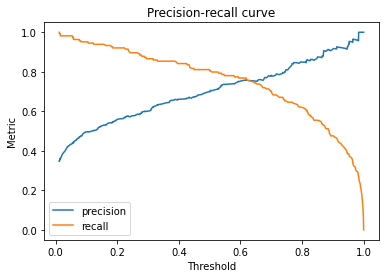

In [20]:
fig = pr_curve(res['y_score'], res['y_true'])

In [21]:
average_precision_score(y_score=res['y_score'], y_true=res['y_true'])

0.8428927120484921

## Performance on vasculature

In [22]:
vasculature_rois = [x.roi_id for x in dataset.dataset if x.project_name == 'add_vasculature']
res[res['roi-id'].isin(vasculature_rois)]['y_pred'].mean()

0.0

In [23]:
len(res[res['roi-id'].isin(vasculature_rois)])

77

### Old model performance on vasculature

In [24]:
old_model = torchvision.models.vgg11_bn(pretrained=True, progress=False)
old_model = VggBackbone(model=old_model, truncate_to_layer=15, classifier_cfg=[512, 512], 
                        freeze_up_to_layer=15)
test_metrics_old, res_old = inference(model=old_model, test_loader=test_loader, 
                              threshold=0.5, checkpoint_path=CHECKPOINT_PATH.parent / '2020_classifier_111721')
res_old['y_true'] = test.y

0_model.pt precision: 0.6637554585152838
0_model.pt recall: 0.926829268292683
0_model.pt f1: 0.7735368956743002
4_model.pt precision: 0.6523605150214592
4_model.pt recall: 0.926829268292683
4_model.pt f1: 0.7657430730478589
2_model.pt precision: 0.6172839506172839
2_model.pt recall: 0.9146341463414634
2_model.pt f1: 0.7371007371007371
1_model.pt precision: 0.7208121827411168
1_model.pt recall: 0.8658536585365854
1_model.pt f1: 0.7867036011080333
3_model.pt precision: 0.5983935742971888
3_model.pt recall: 0.9085365853658537
3_model.pt f1: 0.7215496368038741


In [25]:
print(f'precision: {test_metrics_old.precision}')
print(f'recall: {test_metrics_old.recall}')
print(f'f1: {test_metrics_old.F1}')

precision: 0.6607929515418502
recall: 0.9146341463414634
f1: 0.7672634271099744


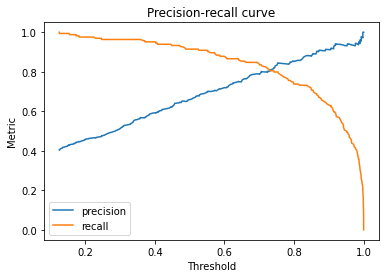

In [26]:
fig = pr_curve(res_old['y_score'], res_old['y_true'])

In [27]:
average_precision_score(y_score=res_old['y_score'], y_true=res_old['y_true'])

0.8882261051159346

In [28]:
res_old[res_old['roi-id'].isin(vasculature_rois)]['y_pred'].mean()

0.22077922077922077